## Product space decision tree

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from hyperdt.product_space_DT import ProductSpace, ProductSpaceDT
from sklearn.tree import DecisionTreeClassifier

INFO: Using numpy backend


### Generate wrapped normal mixture for product space

In [3]:
NUM_POINTS = 1000
NUM_CLASSES = 4
signature = [(3, -1.), (4, -.5), (7, .5), (6, 1.), (5, 0.)]

In [4]:
ps = ProductSpace(signature, seed=0)
ps.sample_clusters(NUM_POINTS, NUM_CLASSES, cov_scale=0.3)
ps.split_data()

### Fit product space DT and compute predictive accuracy

In [5]:
psdt = ProductSpaceDT(product_space=ps, max_depth=3)
psdt.fit()
psdt.score(ps.X_test, ps.y_test)

0.725

### Benchmark analysis vs sklearn

In [6]:
def compute_scores(signature, n=NUM_POINTS, num_classes=NUM_CLASSES, seed=None, cov_scale=0.3, max_depth=3):
    # Generate data
    ps = ProductSpace(signature, seed=seed)
    ps.sample_clusters(n, num_classes, cov_scale=cov_scale)
    ps.split_data()

    # Fit hyperspace decision tree classifier
    psdt = ProductSpaceDT(product_space=ps, max_depth=max_depth)
    psdt.fit()
    psdt_score = psdt.score(ps.X_test, ps.y_test)

    # Fit sklearn's decision tree classifier
    X_train, X_test, y_train, y_test = ps.X_train, ps.X_test, ps.y_train, ps.y_test
    dt = DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(X_train, y_train)
    dt_score = dt.score(X_test, y_test)

    return psdt_score, dt_score

In [7]:
psdt_scores = []
dt_scores = []
rnd_seeds = np.random.randint(0, 1000, 30)

for seed in rnd_seeds:
    psdt_score, dt_score = compute_scores(signature, seed=seed)
    psdt_scores.append(psdt_score)
    dt_scores.append(dt_score)

print(f'avg psdt score: {np.mean(psdt_scores)}')
print(f'avg dt score: {np.mean(dt_scores)}')

avg psdt score: 0.8284999999999999
avg dt score: 0.9249999999999999


In [16]:
# Sort random seeds and corresponding scores
sorted_idx = np.argsort(rnd_seeds)
sorted_rnd_seeds = rnd_seeds[sorted_idx]
sorted_psdt_scores = np.array(psdt_scores)[sorted_idx]
sorted_dt_scores = np.array(dt_scores)[sorted_idx]

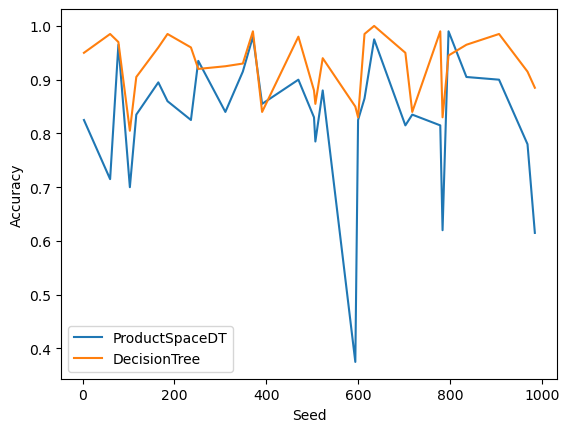

In [19]:
# Plot two lines with psdt_scores and dt_scores vs seed
plt.plot(sorted_rnd_seeds, sorted_psdt_scores, label='ProductSpaceDT')
plt.plot(sorted_rnd_seeds, sorted_dt_scores, label='DecisionTree')
plt.xlabel('Seed')
plt.ylabel('Accuracy')
plt.legend()
plt.show()